In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from dataloader import ANNEDataset
from dataloader import ANNEDataset_transition
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import sys
import json
import shap
sys.path.append(".")
sys.path.append("/scratch/alexhemo/ANNE_dl/")
from preprocessing.main_new_features2 import main, read_strings_from_json,  get_edf_files
                                                                
DATA_DIR = "/scratch/alexhemo/real_new_data/ANNE-PSG140421/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
# device = "cpu"



In [ ]:
fives = ['/home/alexhemo/scratch/data/22-12-07-22_29_59.C4359.L3786.515/22-12-07-22_29_59.C4359.L3786.515-features.edf', '/home/alexhemo/scratch/data/21-08-18-21_37_37.C1425.L1205.303/21-08-18-21_37_37.C1425.L1205.303-features.edf', '/home/alexhemo/scratch/data/23-06-20-21_18_51.C4384.L4041.618/23-06-20-21_18_51.C4384.L4041.618-features.edf', '/home/alexhemo/scratch/data/23-04-24-20_54_48.C4181.L3766.582/23-04-24-20_54_48.C4181.L3766.582-features.edf', '/home/alexhemo/scratch/data/22-03-30-23_13_48.C4151.L3562.375/22-03-30-23_13_48.C4151.L3562.375-features.edf', '/home/alexhemo/scratch/data/21-01-25-21_33_14.C1425.L1205.242/21-01-25-21_33_14.C1425.L1205.242-features.edf', '/home/alexhemo/scratch/data/21-12-14-22_27_58.C3882.L3562.342/21-12-14-22_27_58.C3882.L3562.342-features.edf', '/home/alexhemo/scratch/data/20-11-24-21_39_36.C1459.L1198.223/20-11-24-21_39_36.C1459.L1198.223-features.edf', '/home/alexhemo/scratch/data/21-07-07-22_01_55.C1390.L1215.293/21-07-07-22_01_55.C1390.L1215.293-features.edf', '/home/alexhemo/scratch/data/23-09-26-19_33_55.C4408.L4087.674/23-09-26-19_33_55.C4408.L4087.674-features.edf', '/home/alexhemo/scratch/data/21-07-06-21_42_48.C1390.L1215.292/21-07-06-21_42_48.C1390.L1215.292-features.edf', '/home/alexhemo/scratch/data/23-11-07-19_26_16.C4415.L4084.701/23-11-07-19_26_16.C4415.L4084.701-features.edf', '/home/alexhemo/scratch/data/19-12-17-20_37_24.C823.L775.1/19-12-17-20_37_24.C823.L775.1-features.edf', '/home/alexhemo/scratch/data/21-08-17-21_26_01.C1425.L1205.302/21-08-17-21_26_01.C1425.L1205.302-features.edf', '/home/alexhemo/scratch/data/23-07-04-20_48_04.C4181.L3766.624/23-07-04-20_48_04.C4181.L3766.624-features.edf']
sixes = ['/home/alexhemo/scratch/data/23-09-12-19_38_05.C4408.L4087.666/23-09-12-19_38_05.C4408.L4087.666-features.edf', '/home/alexhemo/scratch/data/22-06-14-22_05_48.C4179.L3806.412/22-06-14-22_05_48.C4179.L3806.412-features.edf', '/home/alexhemo/scratch/data/22-07-20-21_20_47.C4179.L3806.432/22-07-20-21_20_47.C4179.L3806.432-features.edf']
validation_list = fives + sixes

In [2]:
def get_transitions(t):
    t0 = np.copy(t)
    t1 = np.copy(t)
    t2 = np.copy(t)

    t1 = np.concatenate((np.array([0]), t1))
    t2 = np.concatenate((t2, np.array([0])))

    t3 = t2 - t1
    t4 = t3[1:]

    t0 = np.where(t4 != 0, 3, t0) 
    t0 = np.where(t0 != 3, 0, t0)
    t0 = np.where(t0 == 3, 1, t0)
    
    return t0

In [7]:
train_list = get_edf_files("/scratch/alexhemo/CTU_data")
edf = train_list[0]



In [9]:
train_list = get_edf_files("/scratch/alexhemo/real_new_data/ANNE-PSG140421/")
for i in train_list:
    if i.startswith("/scratch/alexhemo/real_new_data/ANNE-PSG140421/23"):
        print(i)
print(len(train_list))

/scratch/alexhemo/real_new_data/ANNE-PSG140421/23-03-21-21_06_20.C4359.L3786.569/23-03-21-21_06_20.C4359.L3786.569-score.edf
180


In [3]:
predict_loaders = []
#train_list = get_edf_files("/home/alexhemo/scratch/data/")
#validation_list = random.sample(train_list, 20)
train_list = get_edf_files("/home/alexhemo/scratch/data/")
#validation_list = random.sample(train_list, 40)
validation_list = read_strings_from_json("./validation_list.json")
#for file in read_strings_from_json("/scratch/alexhemo/ANNE_dl/models/validation.json"):
for file in validation_list:
    X, X_freq, X_scl, t = main(file)
    print(t)
    if isinstance(X, str):
        continue
    X = np.nan_to_num(X, nan=0.5)
    X_freq = np.nan_to_num(X_freq, nan=0.5)
    X_scl = np.nan_to_num(X_scl, nan=0.5)
    t = t[0]
    # t = np.where(t == 1, 0, t)
    # t = np.where(t == 2, 1, t)
    dataset = ANNEDataset_transition(X, X_freq, X_scl, np.array([t]), np.array([get_transitions(t)]), device)
    size = len(X)
    print("appended")
    predict_loaders.append(DataLoader(dataset=dataset, batch_size=size))


# test_dataset = ANNEDataset(X_test, X_freq_test, X_scl_test, t_test, device)
# test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_dataset.__len__())

Extracting EDF parameters from /scratch/alexhemo/real_new_data/ANNE-PSG140421/20-11-03-22_20_46.C1442.L1215.216/20-11-03-22_20_46.C1442.L1215.216-score.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Heart rate shape: (936, 1, 3000)
suffix not found
age: 0.5; sex: 0.5
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1
  1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1
  1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1
  1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0
  0 0 0 0 0 0 0 1 1 0 1

Physical range is not defined in following channels:
plm.events


Heart rate shape: (674, 1, 3000)
suffix not found
age: 0.5; sex: 0.5
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

Physical range is not defined in following channels:
plm.events


Heart rate shape: (1044, 1, 3000)
suffix not found
age: 0.5; sex: 0.5
[[0 0 0 ... 0 0 0]]
appended
Extracting EDF parameters from /scratch/alexhemo/real_new_data/ANNE-PSG140421/21-08-18-21_37_37.C1425.L1205.303/21-08-18-21_37_37.C1425.L1205.303-score.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Physical range is not defined in following channels:
plm.events


Heart rate shape: (1022, 1, 3000)
suffix not found
age: 0.5; sex: 0.5
[[0 0 0 ... 0 0 0]]
appended
Extracting EDF parameters from /scratch/alexhemo/real_new_data/ANNE-PSG140421/22-06-28-22_01_03.C4179.L3806.420/22-06-28-22_01_03.C4179.L3806.420-score.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Physical range is not defined in following channels:
plm.events


Heart rate shape: (977, 1, 3000)
suffix not found
age: 0.5; sex: 0.5
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1
  0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1
  1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

Physical range is not defined in following channels:
plm.events


Heart rate shape: (210, 1, 3000)
suffix not found
age: 0.5; sex: 0.5
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 0]]
appended
Extracting EDF parameters from /scratch/alexhemo/real_new_data/ANNE-PSG140421/21-08-19-22_25_46.C1425.L1205.304/21-08-19-22_25_46.C1425.L1205.304-score.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Physical range is not defined in following channels:
plm.events


Heart rate shape: (579, 1, 3000)
suffix not found
age: 0.5; sex: 0.5
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Physical range is not defined in following channels:
plm.events


Heart rate shape: (586, 1, 3000)
suffix not found
age: 0.5; sex: 0.5
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 0 0 0 0 0 0 0 0 1 1 0 1 1 1
  1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0
  1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

Physical range is not defined in following channels:
plm.events


Heart rate shape: (343, 1, 3000)
suffix not found
age: 0.5; sex: 0.5
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1
  0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1]]
appended
Extracting EDF parameters from /scratch/alexhemo/real_new_data/ANNE-PSG140421/22-03-31-21_53_00.C4151.L3562.376/22-03-31-21_53_00.C4151.L3562.376-score.edf...
EDF file detected
Setting channel info structure...
Cre

Physical range is not defined in following channels:
plm.events


None
Extracting EDF parameters from /scratch/alexhemo/real_new_data/ANNE-PSG140421/20-10-02-21_48_39.C1390.L1217.205/20-10-02-21_48_39.C1390.L1217.205-score.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Physical range is not defined in following channels:
plm.events, SpO2.events


Heart rate shape: (998, 1, 3000)
suffix not found
age: 0.5; sex: 0.5
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1
  1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1
  1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1
  1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1

Physical range is not defined in following channels:
plm.events


Heart rate shape: (997, 1, 3000)
suffix not found
age: 0.5; sex: 0.5
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  1 0 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1
  1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0
  1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1
  1 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0
  1 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1
  1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0
  1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0

In [4]:
targets = []
for train_loader in predict_loaders:
    for i, (inputs, inputs_freq, inputs_scl, labels, transition_labels, lengths) in enumerate(train_loader):
        #print(labels.cpu())
        targets.append(labels.cpu())

In [5]:
from scipy.special import softmax

def predict(model, loader, device, return_softmax=False, transition_model=False, classes=5):
    # Change model to 'eval' mode (BN uses moving mean/var).
    model.eval()

    all_preds = []
    all_labels = []
    all_softmaxes = []

    for i, (inputs, inputs_freq, inputs_scl, labels, transition_labels, lengths) in enumerate(loader):
        with torch.no_grad():
            inputs = inputs.to(device)
            labels = labels.to(device)
            #inputs = inputs.reshape(inputs.shape[0], inputs.shape[1] * inputs.shape[2])
            #inputs_freq = inputs_freq.reshape(inputs_freq.shape[0], inputs_freq.shape[1] * inputs_freq.shape[2])
            #inputs_full = torch.cat((inputs, inputs_freq, inputs_scl), 1)
            
            inputs_freq = inputs_freq.to(device)
            inputs_scl = inputs_scl.to(device)
            # inputs = inputs.view(inputs.size(0), -1)
            
            #inputs_full = torch.flatten(inputs_full)
            #inputs_full = inputs_full.to(device)
            pred = model(inputs, inputs_freq, inputs_scl)
            #pred = model(inputs_full)
        if transition_model:
            cutoff = classes - 2
            pred = pred[:, :cutoff]
        if return_softmax:
            pred = pred.cpu().detach().numpy()
            pred_softmax = softmax(pred, axis=1)
            all_softmaxes.append(pred_softmax)
        else:
            pred = torch.max(pred.data, 1)[1]
            pred_np = pred.cpu().detach().numpy()
            all_preds.append(pred_np)

        labels_np = labels.cpu().detach().numpy()
        all_labels.append(labels_np)
    if return_softmax:
        return np.concatenate(all_labels), np.concatenate(all_softmaxes)
    else:
        return np.concatenate(all_labels), np.concatenate(all_preds)

In [6]:
from scipy.special import softmax

def predict_transition(model, loader, device, return_softmax=False, classes=5):
    # Change model to 'eval' mode (BN uses moving mean/var).
    model.eval()

    all_preds = []
    all_labels = []
    all_softmaxes = []

    for i, (inputs, inputs_freq, inputs_scl, labels, transition_labels, lengths) in enumerate(loader):
        with torch.no_grad():
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.reshape(inputs.shape[0], inputs.shape[1] * inputs.shape[2])
            inputs_freq = inputs_freq.reshape(inputs_freq.shape[0], inputs_freq.shape[1] * inputs_freq.shape[2])
            inputs_full = torch.cat((inputs, inputs_freq, inputs_scl), 1)
            
            inputs_freq = inputs_freq.to(device)
            inputs_scl = inputs_scl.to(device)
            # inputs = inputs.view(inputs.size(0), -1)
            
            inputs_full = torch.flatten(inputs_full)
            inputs_full = inputs_full.to(device)
            #pred = model(inputs, inputs_freq, inputs_scl)
            pred = model(inputs_full)
        cutoff = classes - 2
        pred = pred[:, :cutoff]
        if return_softmax:
            pred = pred.cpu().detach().numpy()
            pred_softmax = softmax(pred, axis=1)
            all_softmaxes.append(pred_softmax)
        else:
            pred = torch.max(pred.data, 1)[1]
            pred_np = pred.cpu().detach().numpy()
            all_preds.append(pred_np)

        labels_np = labels.cpu().detach().numpy()
        all_labels.append(labels_np)
    if return_softmax:
        return np.concatenate(all_labels), np.concatenate(all_softmaxes)
    else:
        return np.concatenate(all_labels), np.concatenate(all_preds)

In [7]:
def ensemble(loader, base_model=None, added_model=None, wake_model=None, nrem_model=None, rem_model=None, no_ppg_model=None,alpha=1):
    
    assert (base_model is not None or 
            added_model is not None or 
            no_ppg_model is not None or 
            (wake_model is not None and nrem_model is not None and rem_model is not None))
    
    softmaxes = []
    
    #if base_model:
    #    labels, base_softmaxes = predict(base_model, loader, device, return_softmax=True)
    #    softmaxes.append(base_softmaxes)
    #                     # / 33.1 ** alpha + base_softmaxes/ 58.7 ** alpha + base_softmaxes / 8.2 ** alpha)
    
    if base_model:
        labels, base_softmaxes = predict(base_model, loader, device, return_softmax=True, transition_model=True)
        softmaxes.append(base_softmaxes)
                         # / 33.1 ** alpha + base_softmaxes/ 58.7 ** alpha + base_softmaxes / 8.2 ** alpha)
    #if transition_model:
    #    labels, base_softmaxes = predict(base_model, loader, device, return_softmax=True, transition_model=True)
    #    softmaxes.append(base_softmaxes)
    if added_model:
        labels, base_softmaxes = predict(added_model, loader, device, return_softmax=True, transition_model=True)
        softmaxes.append(base_softmaxes)
    if wake_model:
        labels, wake_softmaxes = predict(wake_model, loader, device, return_softmax=True, transition_model=True, classes=4)
        wake_softmaxes_3_class = np.column_stack((wake_softmaxes, wake_softmaxes[:, 1]))
        wake_softmaxes_3_class = wake_softmaxes_3_class / np.sum(wake_softmaxes_3_class, axis=1, keepdims=True)
        # softmaxes.append(wake_softmaxes_3_class / 33.1 ** alpha)
        softmaxes.append(wake_softmaxes_3_class / 1.5)
        # softmaxes.append(wake_softmaxes_3_class / 33.1 ** alpha)
    
    if nrem_model:
        labels, nrem_softmaxes = predict(nrem_model, loader, device, return_softmax=True, transition_model=True, classes=4)
        nrem_softmaxes_3_class = np.column_stack((nrem_softmaxes, nrem_softmaxes[:, 0]))
        nrem_softmaxes_3_class = nrem_softmaxes_3_class / np.sum(nrem_softmaxes_3_class, axis=1, keepdims=True)
        softmaxes.append(nrem_softmaxes_3_class)
        #softmaxes.append(nrem_softmaxes_3_class / 58.7 ** alpha)
        #softmaxes.append(nrem_softmaxes_3_class / 4.0)
        
    if rem_model:
        labels, rem_softmaxes = predict(rem_model, loader, device, return_softmax=True)
        rem_softmaxes_3_class = np.column_stack((rem_softmaxes[:, 0], rem_softmaxes))
        rem_softmaxes_3_class = rem_softmaxes_3_class / np.sum(rem_softmaxes_3_class, axis=1, keepdims=True)
        softmaxes.append(rem_softmaxes_3_class)
        # softmaxes.append(rem_softmaxes_3_class / 8.2 ** alpha)
    
    # if no_ppg_model:
    #     labels, no_ppg_softmaxes = predict(no_ppg_model, loader, device, return_softmax=True)
    #     softmaxes.append(no_ppg_softmaxes / 100)
    
    ensembled_softmaxes = np.sum(softmaxes, axis=0)
    ensembled_softmaxes = ensembled_softmaxes / np.sum(ensembled_softmaxes, axis=1, keepdims=True)
    
    return labels, np.argmax(ensembled_softmaxes, axis=1)

In [8]:
#base_model = torch.jit.load("checkpoints/es_20240114-014745.pt")

#transition_model = torch.jit.load("checkpoints/es_20240215-135254.pt")
#transition_model = torch.jit.load("checkpoints/es_20240215-214933.pt")
transition_model = torch.jit.load("checkpoints/tfsnf_rew_20240528-065232.pt")
#added_transition_model = torch.jit.load("checkpoints/model_may_tfs2.pt")
added_transition_model = torch.jit.load("checkpoints/t_nf_rew_20240528-070241.pt")
wake_model = torch.jit.load("checkpoints/tfsnf1_bin_20240529-101552.pt") 
rem_model = torch.jit.load("checkpoints/rem-2-class.pt")
nrem_model = torch.jit.load("checkpoints/nrem-2-class.pt")

time_only_model = torch.jit.load("checkpoints/time_only.pt")

two_class_transition = torch.jit.load("checkpoints/tfsnf5_bin_20240529-181223.pt")
two_class_time_only = torch.jit.load("checkpoints/tnf1_bin_20240529-182713.pt")
nrem_model = torch.jit.load("checkpoints/tfsnf5_bin_nrem_20240531-113508.pt")

bb_t = torch.jit.load("checkpoints/barebones_t_bin.pt")
bb_t_bin = torch.jit.load("checkpoints/barebones_t.pt")

bb_tfs = torch.jit.load("checkpoints/barebones_tfs_20240531-004429.pt")
bb_tfs_bin = torch.jit.load("checkpoints/barebones_t_20240531-004305.pt")



#no_ppg_model = torch.jit.load("checkpoints/es_20240113-233831.pt")

In [ ]:
ensemble(predict_loaders[0], base_model=transition_model, nrem_model = nrem_model
         # , wake_model=wake_model, rem_model=rem_model, nrem_model=nrem_model
         )

18
a
[936, 36]
a
[851, 36]
a
[674, 36]
a
[806, 36]
a
[1044, 36]
a
[1022, 36]
a
[977, 36]
a
[1174, 36]
a
[210, 36]
a
[579, 36]
a
[586, 36]
a
[1106, 36]
a
[1086, 36]
a
[343, 36]
a
[998, 36]
a
[997, 36]
a
[953, 36]
a
[1060, 36]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
<module 'numpy' from '/home/alexhemo/jupyterENV/lib/python3.10/site-packages/numpy/__init__.py'> 94.46666666666667


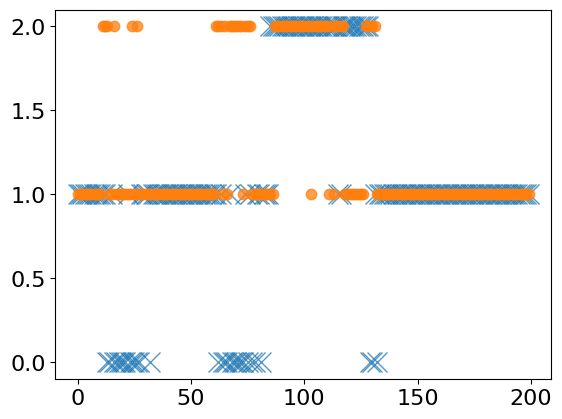

<Figure size 2000x600 with 0 Axes>

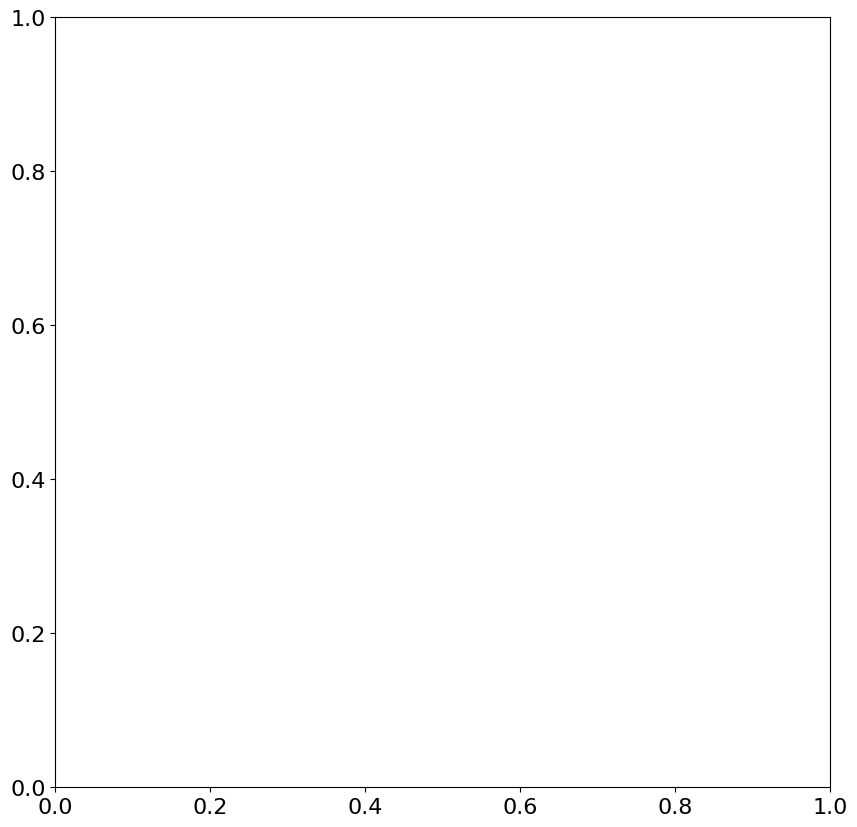

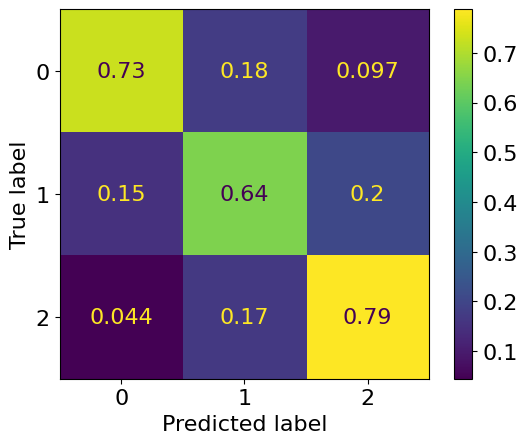

Sensitivity: [0.72711778 0.64378071 0.78789561]
Specificity: [0.86848453 0.82589984 0.84199691]
Precision: [0.77282609 0.78856509 0.39770179]
Class Accuracy: [0.72711778 0.64378071 0.78789561]
Overall Accuracy: 0.6923776132969744
[0.74927549 0.70885535 0.52859005]


0.6622402988941166

In [27]:
labels1 = None
preds1 = None
torch.backends.cudnn.enabled = False 
print(len(predict_loaders))
for test_dataloader in predict_loaders:
    print("a")
    labels, preds = ensemble(test_dataloader, 
                             base_model= added_transition_model, 
                             added_model = transition_model,
                             wake_model=two_class_transition, 
                            # rem_model=rem_model, 
                             nrem_model=nrem_model,
                             alpha=1)
    #labels, preds = predict_transition(transition_model, test_dataloader, device, return_softmax=False, classes=5)
    
    # labels, preds = predict(wake_model, test_dataloader, device=device)
    if labels1 is None:
        labels1, preds1 = labels, preds
    else:
        labels1 = np.concatenate((labels1, labels), axis=0)
        preds1 = np.concatenate((preds1, preds), axis=0)

print(labels1)
print(preds1)
conf_mat = confusion_matrix(labels1, preds1, normalize="true")

print(np, sum(labels1) * 30 / 60 / 60)

plt.plot(labels1[12000:12200], marker="x", linestyle="", alpha=0.75, markersize=15)
plt.plot(preds1[12000:12200], marker=".", linestyle="", alpha=0.75, markersize=15)
plt.figure(figsize=(20,6))
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

sensitivity, specificity, precision, class_accuracy, accuracy  = calculate_metrics(preds1, labels1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Class Accuracy:", class_accuracy)
print("Overall Accuracy:", accuracy)
calculate_macro_f1(preds1, labels1)

[936, 36]
[851, 36]
[674, 36]
[806, 36]
[1044, 36]
[1022, 36]
[977, 36]
[1174, 36]
[210, 36]
[579, 36]
[586, 36]
[1106, 36]
[1086, 36]
[343, 36]
[998, 36]
[997, 36]
[953, 36]
[1060, 36]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
<module 'numpy' from '/home/alexhemo/jupyterENV/lib/python3.10/site-packages/numpy/__init__.py'> 94.46666666666667


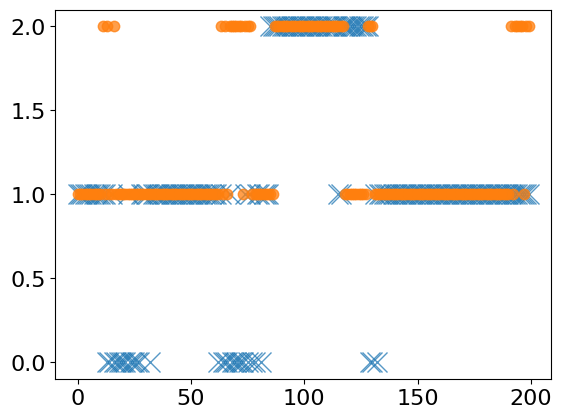

<Figure size 2000x600 with 0 Axes>

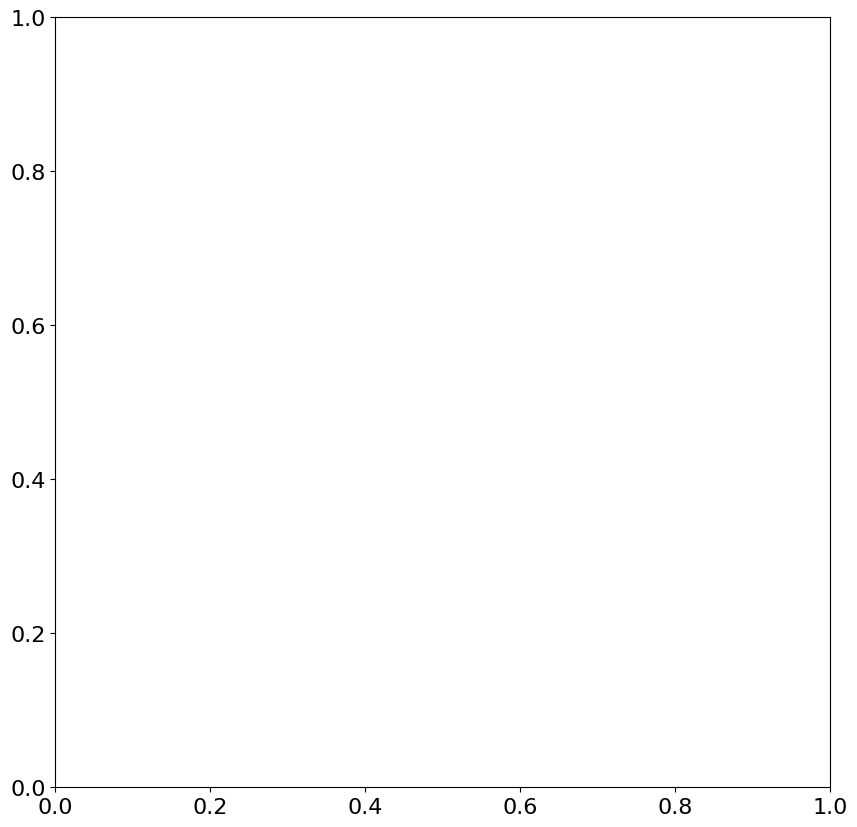

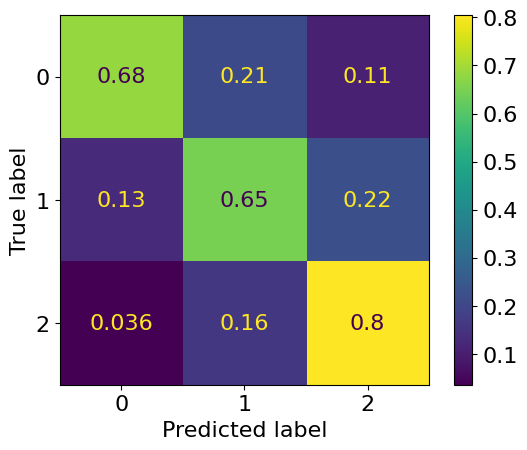

NameError: name 'calculate_metrics' is not defined

In [11]:
labels1 = None
preds1 = None
torch.backends.cudnn.enabled = False 
for test_dataloader in predict_loaders:
    labels, preds = ensemble(test_dataloader, 
                             base_model= added_transition_model, 
                             added_model = transition_model,
                            # wake_model=two_class_transition, 
                            # rem_model=rem_model, 
                            # nrem_model=nrem_model,
                             alpha=1)
    #labels, preds = predict_transition(transition_model, test_dataloader, device, return_softmax=False, classes=5)
    
    # labels, preds = predict(wake_model, test_dataloader, device=device)
    if labels1 is None:
        labels1, preds1 = labels, preds
    else:
        labels1 = np.concatenate((labels1, labels), axis=0)
        preds1 = np.concatenate((preds1, preds), axis=0)

print(labels1)
print(preds1)
conf_mat = confusion_matrix(labels1, preds1, normalize="true")

print(np, sum(labels1) * 30 / 60 / 60)

plt.plot(labels1[12000:12200], marker="x", linestyle="", alpha=0.75, markersize=15)
plt.plot(preds1[12000:12200], marker=".", linestyle="", alpha=0.75, markersize=15)
plt.figure(figsize=(20,6))
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

sensitivity, specificity, precision, class_accuracy, accuracy  = calculate_metrics(preds1, labels1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Class Accuracy:", class_accuracy)
print("Overall Accuracy:", accuracy)
calculate_macro_f1(preds1, labels1)

[936, 36]
[851, 36]
[674, 36]
[806, 36]
[1044, 36]
[1022, 36]
[977, 36]
[1174, 36]
[210, 36]
[579, 36]
[586, 36]
[1106, 36]
[1086, 36]
[343, 36]
[998, 36]
[997, 36]
[953, 36]
[1060, 36]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
<module 'numpy' from '/home/alexhemo/jupyterENV/lib/python3.10/site-packages/numpy/__init__.py'> 94.46666666666667


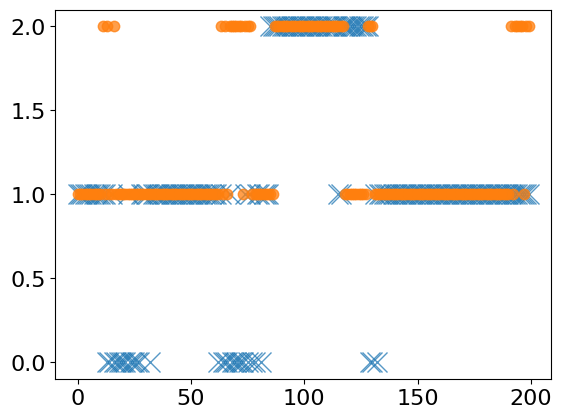

<Figure size 2000x600 with 0 Axes>

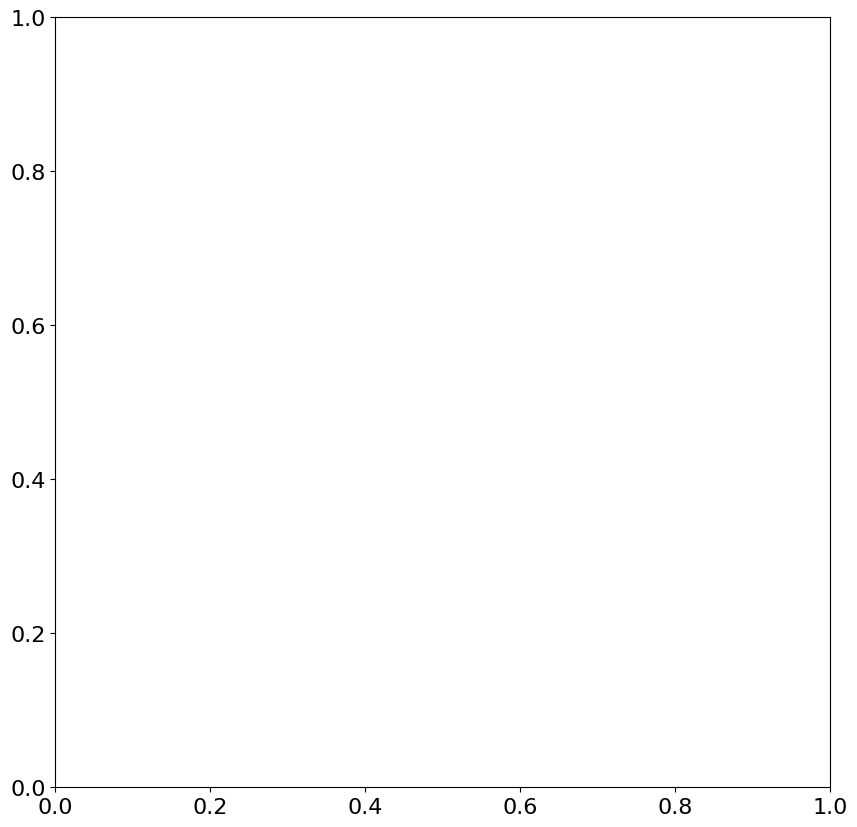

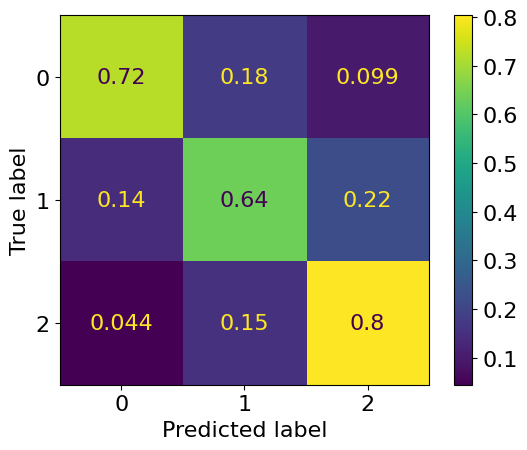

Sensitivity: [0.72217488 0.63679855 0.80399778]
Specificity: [0.87760881 0.82746479 0.83074774]
Precision: [0.78404885 0.78825224 0.38613333]
Class Accuracy: [0.72217488 0.63679855 0.80399778]
Overall Accuracy: 0.6888715751201143
[0.75184101 0.70447718 0.5217078 ]


0.6593419977482591

In [21]:
labels1 = None
preds1 = None
torch.backends.cudnn.enabled = False 
for test_dataloader in predict_loaders:
    labels, preds = ensemble(test_dataloader, 
                             base_model= added_transition_model, 
                             added_model = transition_model,
                             wake_model=two_class_transition, 
                            # rem_model=rem_model, 
                            # nrem_model=nrem_model,
                             alpha=1)
    #labels, preds = predict_transition(transition_model, test_dataloader, device, return_softmax=False, classes=5)
    
    # labels, preds = predict(wake_model, test_dataloader, device=device)
    if labels1 is None:
        labels1, preds1 = labels, preds
    else:
        labels1 = np.concatenate((labels1, labels), axis=0)
        preds1 = np.concatenate((preds1, preds), axis=0)

print(labels1)
print(preds1)
conf_mat = confusion_matrix(labels1, preds1, normalize="true")

print(np, sum(labels1) * 30 / 60 / 60)

plt.plot(labels1[12000:12200], marker="x", linestyle="", alpha=0.75, markersize=15)
plt.plot(preds1[12000:12200], marker=".", linestyle="", alpha=0.75, markersize=15)
plt.figure(figsize=(20,6))
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

sensitivity, specificity, precision, class_accuracy, accuracy  = calculate_metrics(preds1, labels1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Class Accuracy:", class_accuracy)
print("Overall Accuracy:", accuracy)
calculate_macro_f1(preds1, labels1)

[936, 36]
[851, 36]
[674, 36]
[806, 36]
[1044, 36]
[1022, 36]
[977, 36]
[1174, 36]
[210, 36]
[579, 36]
[586, 36]
[1106, 36]
[1086, 36]
[343, 36]
[998, 36]
[997, 36]
[953, 36]
[1060, 36]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
<module 'numpy' from '/home/alexhemo/jupyterENV/lib/python3.10/site-packages/numpy/__init__.py'> 94.46666666666667


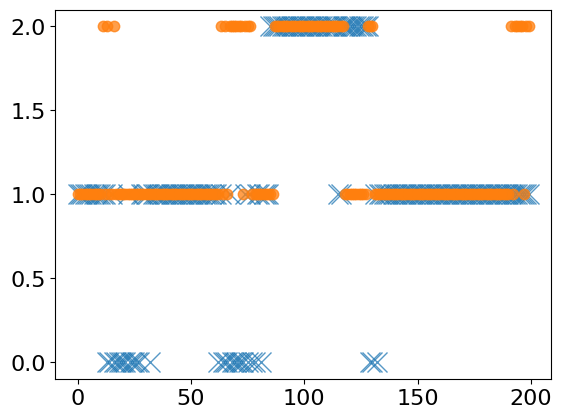

<Figure size 2000x600 with 0 Axes>

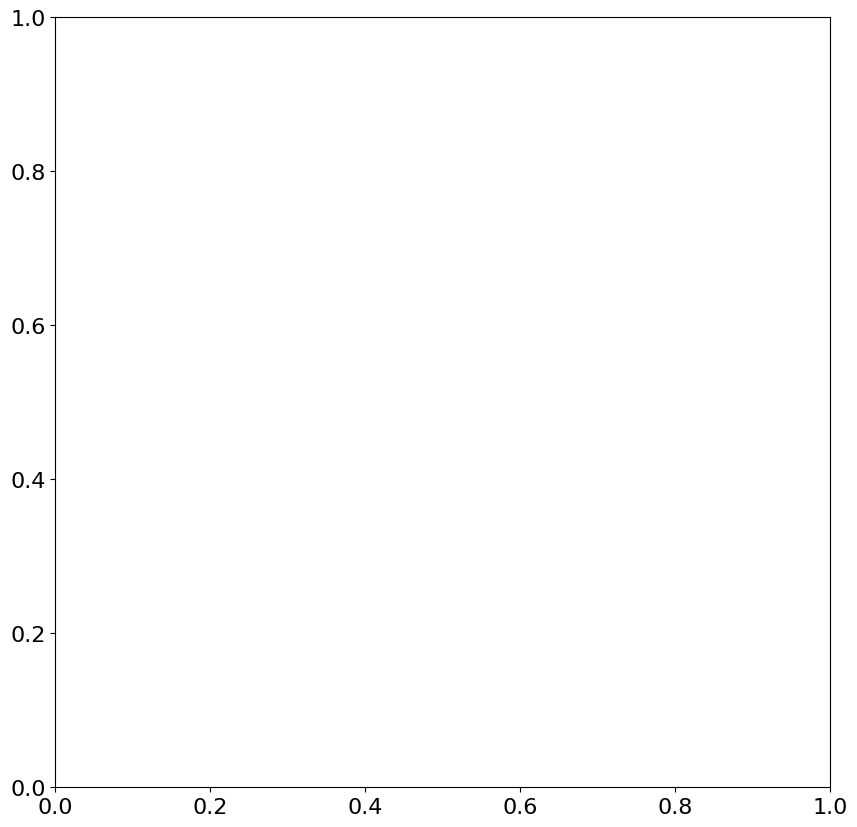

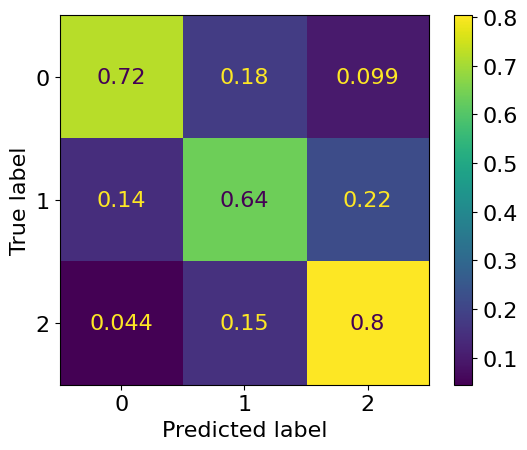

Sensitivity: [0.72353844 0.63537626 0.80399778]
Specificity: [0.87593078 0.82824726 0.83126241]
Precision: [0.78205601 0.78863746 0.38685546]
Class Accuracy: [0.72353844 0.63537626 0.80399778]
Overall Accuracy: 0.6886767952213998
[0.75166003 0.7037594  0.52236652]


0.659261982474396

In [15]:
labels1 = None
preds1 = None
torch.backends.cudnn.enabled = False 
for test_dataloader in predict_loaders:
    labels, preds = ensemble(test_dataloader, 
                             base_model= added_transition_model, 
                             added_model = transition_model,
                             wake_model=two_class_transition, 
                            # rem_model=rem_model, 
                            # nrem_model=nrem_model,
                             alpha=1)
    #labels, preds = predict_transition(transition_model, test_dataloader, device, return_softmax=False, classes=5)
    
    # labels, preds = predict(wake_model, test_dataloader, device=device)
    if labels1 is None:
        labels1, preds1 = labels, preds
    else:
        labels1 = np.concatenate((labels1, labels), axis=0)
        preds1 = np.concatenate((preds1, preds), axis=0)

print(labels1)
print(preds1)
conf_mat = confusion_matrix(labels1, preds1, normalize="true")

print(np, sum(labels1) * 30 / 60 / 60)

plt.plot(labels1[12000:12200], marker="x", linestyle="", alpha=0.75, markersize=15)
plt.plot(preds1[12000:12200], marker=".", linestyle="", alpha=0.75, markersize=15)
plt.figure(figsize=(20,6))
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

sensitivity, specificity, precision, class_accuracy, accuracy  = calculate_metrics(preds1, labels1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Class Accuracy:", class_accuracy)
print("Overall Accuracy:", accuracy)
calculate_macro_f1(preds1, labels1)

In [ ]:
labels1 = None
preds1 = None
torch.backends.cudnn.enabled = False 
for test_dataloader in predict_loaders:
    #labels, preds = ensemble(test_dataloader, 
                           #  base_model= added_transition_model, 
                           #  added_model = transition_model,
     #                        wake_model=two_class_transition, 
                            # rem_model=rem_model, 
                            # nrem_model=nrem_model,
     #                        alpha=1)
    #labels, preds = predict_transition(transition_model, test_dataloader, device, return_softmax=False, classes=5)
    
    labels, preds = predict(two_class_time_only, test_dataloader, device=device, transition_model=True, return_softmax=False, classes=4)
    labels = np.where(labels == 2, 1, labels)
    if labels1 is None:
        labels1, preds1 = labels, preds
    else:
        labels1 = np.concatenate((labels1, labels), axis=0)
        preds1 = np.concatenate((preds1, preds), axis=0)

print(labels1)
print(preds1)
conf_mat = confusion_matrix(labels1, preds1, normalize="true")

print(np, sum(labels1) * 30 / 60 / 60)

plt.plot(labels1[12000:12200], marker="x", linestyle="", alpha=0.75, markersize=15)
plt.plot(preds1[12000:12200], marker=".", linestyle="", alpha=0.75, markersize=15)
plt.figure(figsize=(20,6))
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

sensitivity, specificity, precision, class_accuracy, accuracy  = calculate_metrics(preds1, labels1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Class Accuracy:", class_accuracy)
print("Overall Accuracy:", accuracy)
calculate_macro_f1(preds1, labels1)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
<module 'numpy' from '/home/alexhemo/jupyterENV/lib/python3.10/site-packages/numpy/__init__.py'> 79.45833333333333


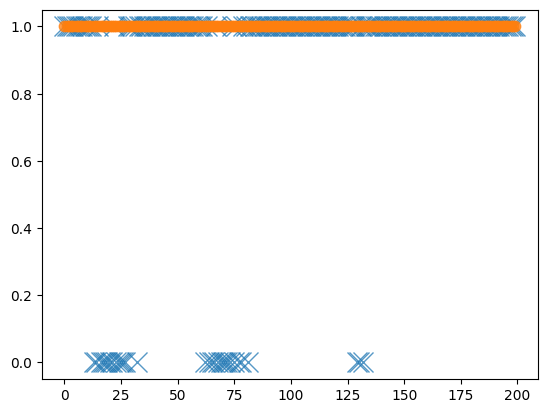

<Figure size 2000x600 with 0 Axes>

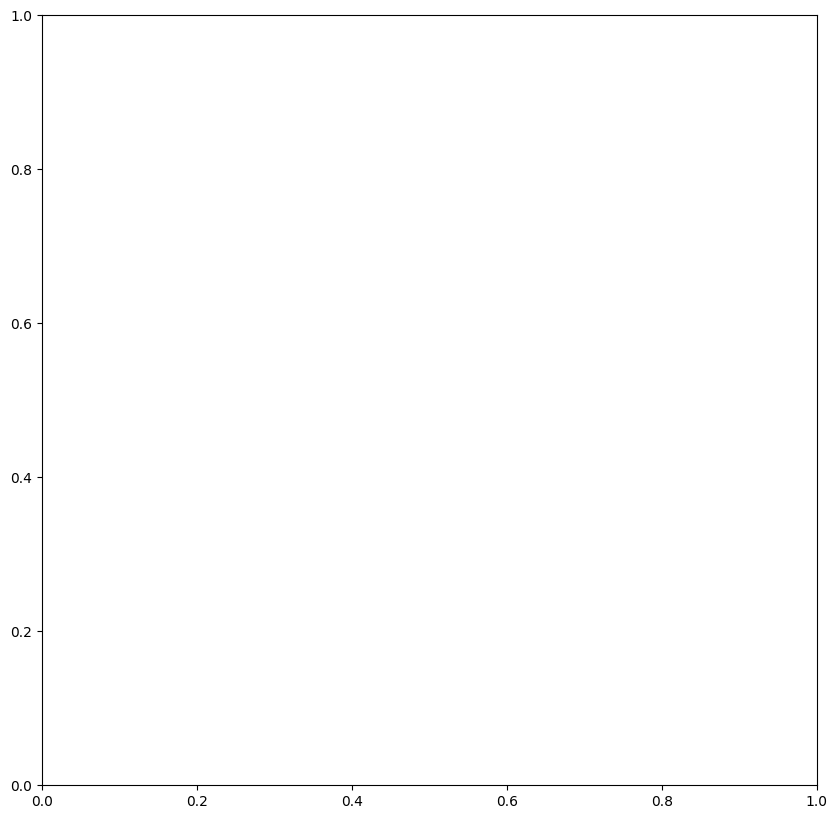

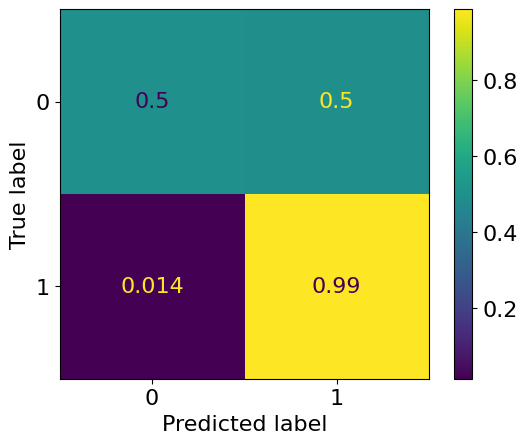

NameError: name 'calculate_metrics' is not defined

In [9]:
labels1 = None
preds1 = None
torch.backends.cudnn.enabled = False 
for test_dataloader in predict_loaders:
    #labels, preds = ensemble(test_dataloader, 
                           #  base_model= added_transition_model, 
                           #  added_model = transition_model,
     #                        wake_model=two_class_transition, 
                            # rem_model=rem_model, 
                            # nrem_model=nrem_model,
     #                        alpha=1)
    #labels, preds = predict_transition(transition_model, test_dataloader, device, return_softmax=False, classes=5)
    
    labels, preds = predict(nrem_model, test_dataloader, device=device, transition_model=True, return_softmax=False, classes=4)
    labels = np.where(labels == 2, 1, labels)
    if labels1 is None:
        labels1, preds1 = labels, preds
    else:
        labels1 = np.concatenate((labels1, labels), axis=0)
        preds1 = np.concatenate((preds1, preds), axis=0)

print(labels1)
print(preds1)
conf_mat = confusion_matrix(labels1, preds1, normalize="true")

print(np, sum(labels1) * 30 / 60 / 60)

plt.plot(labels1[12000:12200], marker="x", linestyle="", alpha=0.75, markersize=15)
plt.plot(preds1[12000:12200], marker=".", linestyle="", alpha=0.75, markersize=15)
plt.figure(figsize=(20,6))
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

sensitivity, specificity, precision, class_accuracy, accuracy  = calculate_metrics(preds1, labels1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Class Accuracy:", class_accuracy)
print("Overall Accuracy:", accuracy)
calculate_macro_f1(preds1, labels1)

In [ ]:
conf_mat = [[0.72998785 0.11529779 0.15471436]
 [0.1061604  0.64626114 0.24757846]
 [0.01233118 0.27950675 0.70816207]]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

In [9]:
def calculate_metrics(predictions, labels):
    # Create confusion matrix
    conf_matrix = confusion_matrix(labels, predictions)

    # Calculate metrics for each class
    num_classes = conf_matrix.shape[0]

    sensitivity = np.zeros(num_classes)
    specificity = np.zeros(num_classes)
    precision = np.zeros(num_classes)
    class_accuracy = np.zeros(num_classes)

    for i in range(num_classes):
        # True Positives for class i
        TP = conf_matrix[i, i]

        # False Positives for class i
        FP = conf_matrix[:, i].sum() - TP

        # False Negatives for class i
        FN = conf_matrix[i, :].sum() - TP

        # True Negatives for class i
        TN = conf_matrix.sum() - (TP + FP + FN)

        # Sensitivity (Recall) for class i
        sensitivity[i] = TP / (TP + FN) if TP + FN != 0 else 0.0

        # Specificity for class i
        specificity[i] = TN / (TN + FP) if TN + FP != 0 else 0.0

        # Precision for class i
        precision[i] = TP / (TP + FP) if TP + FP != 0 else 0.0

        # Per-class accuracy
        class_accuracy[i] = TP / (TP + FN) if TP + FN != 0 else 0.0

    # Overall accuracy
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

    return sensitivity, specificity, precision, class_accuracy, accuracy

In [27]:
sensitivity, specificity, precision, class_accuracy, accuracy  = calculate_metrics(preds1, labels1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Class Accuracy:", class_accuracy)
print("Overall Accuracy:", accuracy)

Sensitivity: [0.66977956 0.81261576 0.8047025 ]
Specificity: [0.9649212  0.79376605 0.86653986]
Precision: [0.93710119 0.77224721 0.39900071]
Class Accuracy: [0.66977956 0.81261576 0.8047025 ]
Overall Accuracy: 0.7492265955927847


In [10]:
import numpy as np
from sklearn.metrics import precision_score, recall_score
def calculate_macro_f1(predictions, labels, average='macro'):
    # Calculate precision and recall for each class
    precision = precision_score(labels, predictions, average=None, zero_division=0)
    recall = recall_score(labels, predictions, average=None, zero_division=0)

    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall)

    # Calculate macro F1 score
    print(f1)
    macro_f1 = np.mean(f1)

    return macro_f1

In [29]:
calculate_macro_f1(preds1, labels1)

[0.78120448 0.79191737 0.53348179]


0.7022012133382957

In [30]:
from sklearn.metrics import f1_score
f1_score(labels1, preds1, average="macro")

0.7022012133382957

In [ ]:
explainer = shap.KernelExplainer(transition_model, predict_loaders)

shap_values = explainer.shap_values(predict_loaders)

shap.initjs()



[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
<module 'numpy' from '/home/alexhemo/jupyterENV/lib/python3.10/site-packages/numpy/__init__.py'> 94.46666666666667


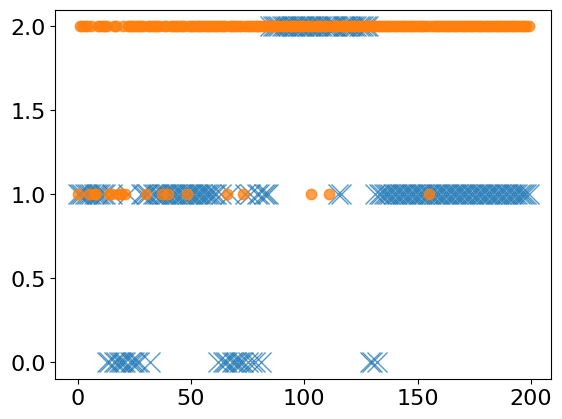

<Figure size 2000x600 with 0 Axes>

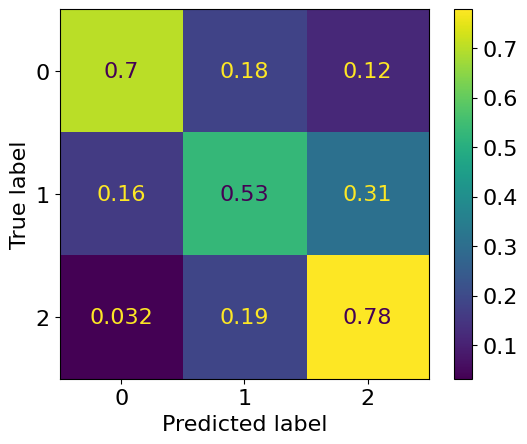

Sensitivity: [0.70018749 0.52999741 0.77845641]
Specificity: [0.86166754 0.81624935 0.77464892]
Precision: [0.75695596 0.74419027 0.31385717]
Class Accuracy: [0.70018749 0.52999741 0.77845641]
Overall Accuracy: 0.6238800155823919
[0.72746591 0.61909077 0.44735163]


0.5979694367344391

In [38]:
labels1 = None
preds1 = None
torch.backends.cudnn.enabled = False 
for test_dataloader in predict_loaders:
    labels, preds = ensemble(test_dataloader, 
                            # base_model=added_transition_model, 
                             added_model = transition_model,
                            # wake_model=two_class_transition, 
                            # rem_model=rem_model, 
                            # nrem_model=nrem_model,
                             alpha=1)
    #labels, preds = predict_transition(transition_model, test_dataloader, device, return_softmax=False, classes=5)
    
    # labels, preds = predict(wake_model, test_dataloader, device=device)
    if labels1 is None:
        labels1, preds1 = labels, preds
    else:
        labels1 = np.concatenate((labels1, labels), axis=0)
        preds1 = np.concatenate((preds1, preds), axis=0)

print(labels1)
print(preds1)
conf_mat = confusion_matrix(labels1, preds1, normalize="true")

print(np, sum(labels1) * 30 / 60 / 60)

plt.plot(labels1[12000:12200], marker="x", linestyle="", alpha=0.75, markersize=15)
plt.plot(preds1[12000:12200], marker=".", linestyle="", alpha=0.75, markersize=15)
plt.figure(figsize=(20,6))
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

sensitivity, specificity, precision, class_accuracy, accuracy  = calculate_metrics(preds1, labels1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Class Accuracy:", class_accuracy)
print("Overall Accuracy:", accuracy)
calculate_macro_f1(preds1, labels1)

In [ ]:
labels1 = None
preds1 = None
torch.backends.cudnn.enabled = False 
for test_dataloader in predict_loaders:
    labels, preds = ensemble(test_dataloader, 
                            # base_model=transition_model, 
                             added_model = bb_tfs,
                            # wake_model=two_class_transition, 
                            # rem_model=rem_model, 
                            # nrem_model=nrem_model,
                             alpha=1)
    #labels, preds = predict_transition(transition_model, test_dataloader, device, return_softmax=False, classes=5)
    
    # labels, preds = predict(wake_model, test_dataloader, device=device)
    if labels1 is None:
        labels1, preds1 = labels, preds
    else:
        labels1 = np.concatenate((labels1, labels), axis=0)
        preds1 = np.concatenate((preds1, preds), axis=0)

print(labels1)
print(preds1)
conf_mat = confusion_matrix(labels1, preds1, normalize="true")

print(np, sum(labels1) * 30 / 60 / 60)

plt.plot(labels1[12000:12200], marker="x", linestyle="", alpha=0.75, markersize=15)
plt.plot(preds1[12000:12200], marker=".", linestyle="", alpha=0.75, markersize=15)
plt.figure(figsize=(20,6))
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

sensitivity, specificity, precision, class_accuracy, accuracy  = calculate_metrics(preds1, labels1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Class Accuracy:", class_accuracy)
print("Overall Accuracy:", accuracy)
calculate_macro_f1(preds1, labels1)


[1061, 48]
[1079, 48]
[1036, 48]
[1051, 48]
[983, 48]
[1003, 48]
[204, 48]
[1043, 48]
[1120, 48]
[1144, 48]
[410, 48]
[1074, 48]
[1112, 48]
[1244, 48]
[1047, 48]
[1001, 48]
[904, 48]
[1095, 48]
[1162, 48]
[1023, 48]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
<module 'numpy' from '/home/alexhemo/jupyterENV/lib/python3.10/site-packages/numpy/__init__.py'> 105.68333333333334


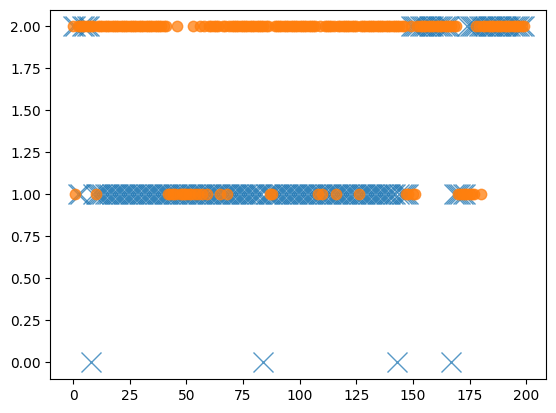

<Figure size 2000x600 with 0 Axes>

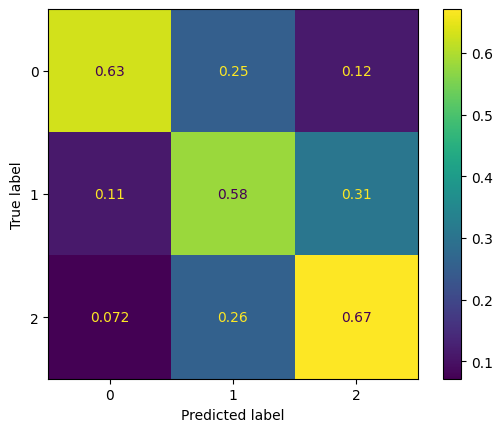

Sensitivity: [0.63015582 0.58187011 0.67100372]
Specificity: [0.89410914 0.74531038 0.78517215]
Precision: [0.82434053 0.67621389 0.21707757]
Class Accuracy: [0.63015582 0.58187011 0.67100372]
Overall Accuracy: 0.6104263487573247
[0.71428571 0.62550458 0.32803271]


0.555941001137752

In [17]:
labels1 = None
preds1 = None
torch.backends.cudnn.enabled = False 
for test_dataloader in predict_loaders:
    labels, preds = ensemble(test_dataloader, 
                             base_model=added_transition_model, 
                             added_model = transition_model,
                            # wake_model=two_class_transition, 
                            # rem_model=rem_model, 
                            # nrem_model=nrem_model,
                             alpha=1)
    #labels, preds = predict_transition(transition_model, test_dataloader, device, return_softmax=False, classes=5)
    
    # labels, preds = predict(wake_model, test_dataloader, device=device)
    if labels1 is None:
        labels1, preds1 = labels, preds
    else:
        labels1 = np.concatenate((labels1, labels), axis=0)
        preds1 = np.concatenate((preds1, preds), axis=0)

print(labels1)
print(preds1)
conf_mat = confusion_matrix(labels1, preds1, normalize="true")

print(np, sum(labels1) * 30 / 60 / 60)

plt.plot(labels1[12000:12200], marker="x", linestyle="", alpha=0.75, markersize=15)
plt.plot(preds1[12000:12200], marker=".", linestyle="", alpha=0.75, markersize=15)
plt.figure(figsize=(20,6))
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

sensitivity, specificity, precision, class_accuracy, accuracy  = calculate_metrics(preds1, labels1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Class Accuracy:", class_accuracy)
print("Overall Accuracy:", accuracy)
calculate_macro_f1(preds1, labels1)


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
<module 'numpy' from '/home/alexhemo/jupyterENV/lib/python3.10/site-packages/numpy/__init__.py'> 92.23333333333333


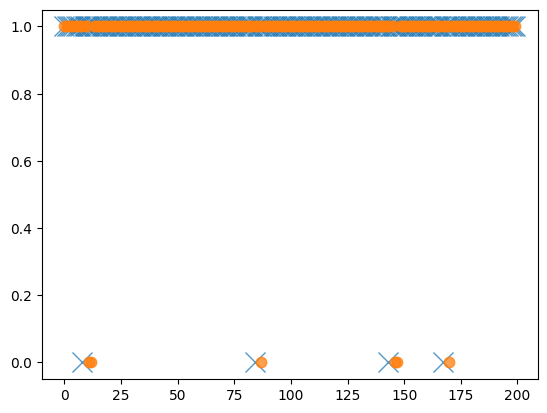

<Figure size 2000x600 with 0 Axes>

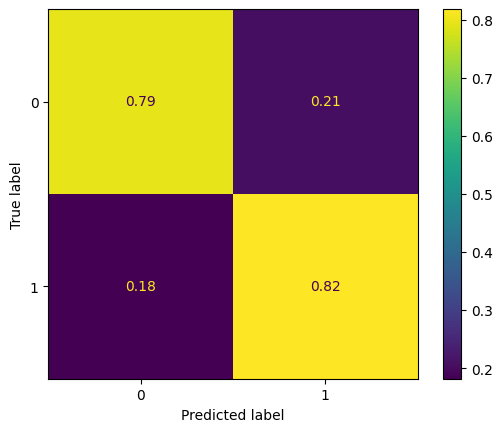

Sensitivity: [0.79445463 0.81812432]
Specificity: [0.81812432 0.79445463]
Precision: [0.77500838 0.83463914]
Class Accuracy: [0.79445463 0.81812432]
Overall Accuracy: 0.8076884219034148
[0.78461103 0.82629922]


0.8054551261577769

In [35]:
labels1 = None
preds1 = None
torch.backends.cudnn.enabled = False 
for test_dataloader in predict_loaders:
    #labels, preds = ensemble(test_dataloader, 
    #                         base_model=added_transition_model, 
    #                         added_model = transition_model,
                            # wake_model=two_class_transition, 
                            # rem_model=rem_model, 
                            # nrem_model=nrem_model,
    #                         alpha=1)
    #labels, preds = predict_transition(transition_model, test_dataloader, device, return_softmax=False, classes=5)
    
    labels, preds = predict(two_class_transition, test_dataloader, device=device, transition_model=True, return_softmax=False, classes=4)
    labels = np.where(labels == 2, 1, labels)
    if labels1 is None:
        labels1, preds1 = labels, preds
    else:
        labels1 = np.concatenate((labels1, labels), axis=0)
        preds1 = np.concatenate((preds1, preds), axis=0)

print(labels1)
print(preds1)
conf_mat = confusion_matrix(labels1, preds1, normalize="true")

print(np, sum(labels1) * 30 / 60 / 60)

plt.plot(labels1[12000:12200], marker="x", linestyle="", alpha=0.75, markersize=15)
plt.plot(preds1[12000:12200], marker=".", linestyle="", alpha=0.75, markersize=15)
plt.figure(figsize=(20,6))
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

sensitivity, specificity, precision, class_accuracy, accuracy  = calculate_metrics(preds1, labels1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Class Accuracy:", class_accuracy)
print("Overall Accuracy:", accuracy)
calculate_macro_f1(preds1, labels1)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
<module 'numpy' from '/home/alexhemo/jupyterENV/lib/python3.10/site-packages/numpy/__init__.py'> 79.45833333333333


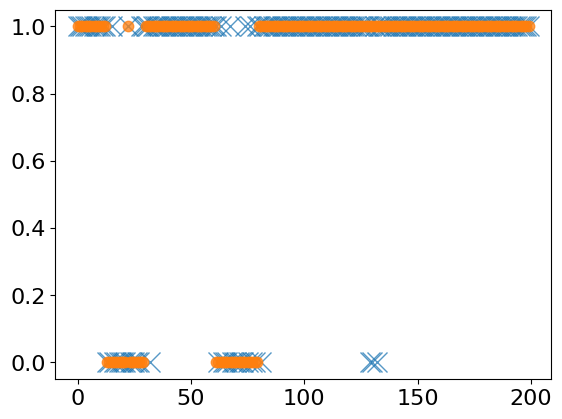

<Figure size 2000x600 with 0 Axes>

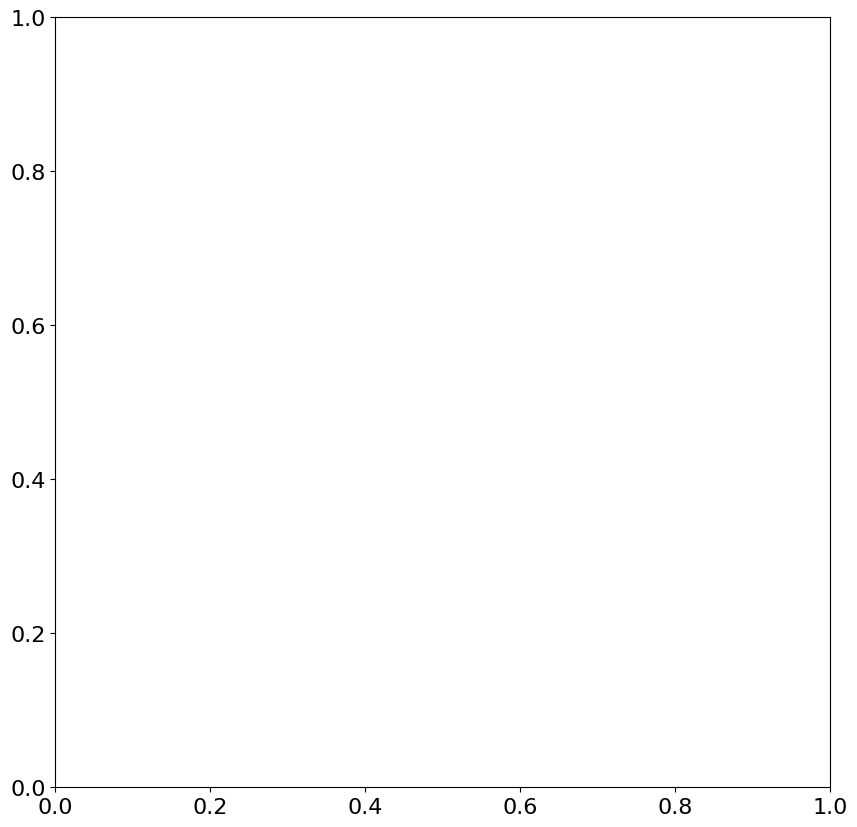

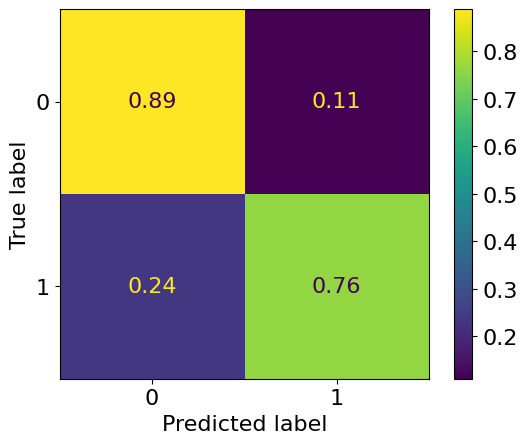

Sensitivity: [0.88921084 0.76213949]
Specificity: [0.76213949 0.88921084]
Precision: [0.69699399 0.91789819]
Class Accuracy: [0.88921084 0.76213949]
Overall Accuracy: 0.8105440851837423
[0.78145596 0.83279853]


0.807127247386549

In [18]:
labels1 = None
preds1 = None
torch.backends.cudnn.enabled = False 
for test_dataloader in predict_loaders:
    #labels, preds = ensemble(test_dataloader, 
                           #  base_model= added_transition_model, 
                           #  added_model = transition_model,
     #                        wake_model=two_class_transition, 
                            # rem_model=rem_model, 
                            # nrem_model=nrem_model,
     #                        alpha=1)
    #labels, preds = predict_transition(transition_model, test_dataloader, device, return_softmax=False, classes=5)
    
    labels, preds = predict(two_class_transition, test_dataloader, device=device, transition_model=True, return_softmax=False, classes=4)
    labels = np.where(labels == 2, 1, labels)
    if labels1 is None:
        labels1, preds1 = labels, preds
    else:
        labels1 = np.concatenate((labels1, labels), axis=0)
        preds1 = np.concatenate((preds1, preds), axis=0)

print(labels1)
print(preds1)
conf_mat = confusion_matrix(labels1, preds1, normalize="true")

print(np, sum(labels1) * 30 / 60 / 60)

plt.plot(labels1[12000:12200], marker="x", linestyle="", alpha=0.75, markersize=15)
plt.plot(preds1[12000:12200], marker=".", linestyle="", alpha=0.75, markersize=15)
plt.figure(figsize=(20,6))
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

sensitivity, specificity, precision, class_accuracy, accuracy  = calculate_metrics(preds1, labels1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Class Accuracy:", class_accuracy)
print("Overall Accuracy:", accuracy)
calculate_macro_f1(preds1, labels1)

In [ ]:
labels1 = None
preds1 = None
torch.backends.cudnn.enabled = False 
for test_dataloader in predict_loaders:
    #labels, preds = ensemble(test_dataloader, 
                           #  base_model= added_transition_model, 
                           #  added_model = transition_model,
     #                        wake_model=two_class_transition, 
                            # rem_model=rem_model, 
                            # nrem_model=nrem_model,
     #                        alpha=1)
    #labels, preds = predict_transition(transition_model, test_dataloader, device, return_softmax=False, classes=5)
    
    labels, preds = predict(bb_tfs_bin, test_dataloader, device=device, transition_model=True, return_softmax=False, classes=4)
    labels = np.where(labels == 2, 1, labels)
    if labels1 is None:
        labels1, preds1 = labels, preds
    else:
        labels1 = np.concatenate((labels1, labels), axis=0)
        preds1 = np.concatenate((preds1, preds), axis=0)

print(labels1)
print(preds1)
conf_mat = confusion_matrix(labels1, preds1, normalize="true")

print(np, sum(labels1) * 30 / 60 / 60)

plt.plot(labels1[12000:12200], marker="x", linestyle="", alpha=0.75, markersize=15)
plt.plot(preds1[12000:12200], marker=".", linestyle="", alpha=0.75, markersize=15)
plt.figure(figsize=(20,6))
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

sensitivity, specificity, precision, class_accuracy, accuracy  = calculate_metrics(preds1, labels1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Class Accuracy:", class_accuracy)
print("Overall Accuracy:", accuracy)
calculate_macro_f1(preds1, labels1)


In [ ]:
labels, wake_softmaxes = predict(wake_model, loader, device, return_softmax=True, transition_model=True, classes=4)
        wake_softmaxes_3_class = np.column_stack((wake_softmaxes, wake_softmaxes[:, 1]))
        wake_softmaxes_3_class = wake_softmaxes_3_class / np.sum(wake_softmaxes_3_class, axis=1, keepdims=True)
        # softmaxes.append(wake_softmaxes_3_class / 33.1 ** alpha)
        softmaxes.append(wake_softmaxes_3_class / 1.5)
        # softmaxes.append(wake_softmaxes_3_class / 33.1 ** alpha)
    
    if nrem_model:
        labels, nrem_softmaxes = predict(nrem_model, loader, device, return_softmax=True, transition_model=True, classes=4)
        nrem_softmaxes_3_class = np.column_stack((nrem_softmaxes, nrem_softmaxes[:, 0]))
        nrem_softmaxes_3_class = nrem_softmaxes_3_class / np.sum(nrem_softmaxes_3_class, axis=1, keepdims=True)
        softmaxes.append(nrem_softmaxes_3_class)
        #softmaxes.append(nrem_softmaxes_3_class / 58.7 ** alpha)
        #softmaxes.append(nrem_softmaxes_3_class / 4.0)
        
    if rem_model:
        labels, rem_softmaxes = predict(rem_model, loader, device, return_softmax=True)
        rem_softmaxes_3_class = np.column_stack((rem_softmaxes[:, 0], rem_softmaxes))
        rem_softmaxes_3_class = rem_softmaxes_3_class / np.sum(rem_softmaxes_3_class, axis=1, keepdims=True)
        softmaxes.append(rem_softmaxes_3_class)
        # softmaxes.append(rem_softmaxes_3_class / 8.2 ** alpha)
    
    # if no_ppg_model:
    #     labels, no_ppg_softmaxes = predict(no_ppg_model, loader, device, return_softmax=True)
    #     softmaxes.append(no_ppg_softmaxes / 100)
    
    ensembled_softmaxes = np.sum(softmaxes, axis=0)
    ensembled_softmaxes = ensembled_softmaxes / np.sum(ensembled_softmaxes, axis=1, keepdims=True)

In [41]:
from scipy.special import softmax

def predict(model, loader, device, return_softmax=False, transition_model=False, classes=5):
    # Change model to 'eval' mode (BN uses moving mean/var).
    model.eval()

    all_preds = []
    all_labels = []
    all_softmaxes = []

    for i, (inputs, inputs_freq, inputs_scl, labels, transition_labels, lengths) in enumerate(loader):
        with torch.no_grad():
            inputs = inputs.to(device)
            labels = labels.to(device)
            #inputs = inputs.reshape(inputs.shape[0], inputs.shape[1] * inputs.shape[2])
            #inputs_freq = inputs_freq.reshape(inputs_freq.shape[0], inputs_freq.shape[1] * inputs_freq.shape[2])
            #inputs_full = torch.cat((inputs, inputs_freq, inputs_scl), 1)
            
            inputs_freq = inputs_freq.to(device)
            inputs_scl = inputs_scl.to(device)
            # inputs = inputs.view(inputs.size(0), -1)
            
            #inputs_full = torch.flatten(inputs_full)
            #inputs_full = inputs_full.to(device)
            pred = model(inputs, inputs_freq, inputs_scl)
            #pred = model(inputs_full)
        if transition_model:
            cutoff = classes - 2
            pred = pred[:, :cutoff]
        if return_softmax:
            pred = pred.cpu().detach().numpy()
            pred_softmax = softmax(pred, axis=1)
            all_softmaxes.append(pred_softmax)
        else:
            pred = torch.max(pred.data, 1)[1]
            pred_np = pred.cpu().detach().numpy()
            all_preds.append(pred_np)

        labels_np = labels.cpu().detach().numpy()
        all_labels.append(labels_np)
    if return_softmax:
        return np.concatenate(all_labels), np.concatenate(all_softmaxes)
    else:
        return np.concatenate(all_labels), np.concatenate(all_preds)

18
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
<module 'numpy' from '/home/alexhemo/jupyterENV/lib/python3.10/site-packages/numpy/__init__.py'> 79.45833333333333


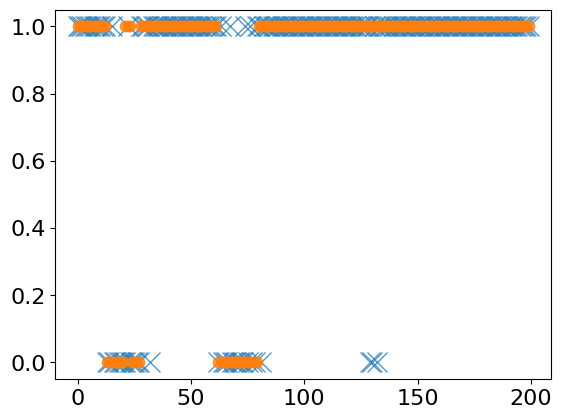

<Figure size 2000x600 with 0 Axes>

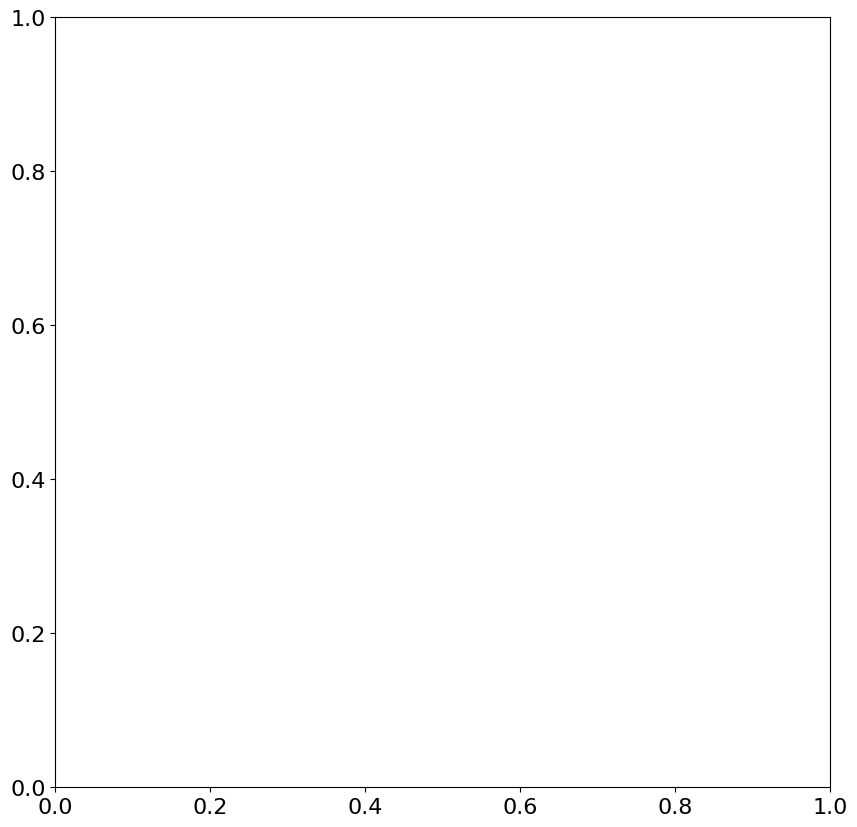

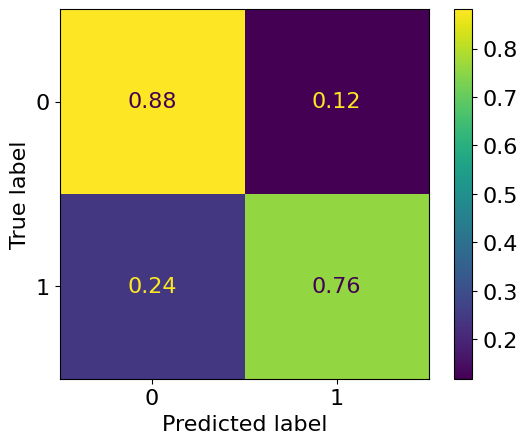

Sensitivity: [0.88154082 0.75825905]
Specificity: [0.75825905 0.88154082]
Precision: [0.69172128 0.91230284]
Class Accuracy: [0.88154082 0.75825905]
Overall Accuracy: 0.8052201012855473
[0.77517986 0.82817869]


0.8016792751365918

In [50]:
labels1 = None
preds1 = None
torch.backends.cudnn.enabled = False 
print(len(predict_loaders))
for test_dataloader in predict_loaders:
    print("a")
    #labels, preds = ensemble(test_dataloader, 
                            # base_model= bb_t, 
                            # added_model = transition_model,
                            # wake_model=two_class_transition, 
                            # rem_model=rem_model, 
                            # nrem_model=nrem_model,
    #                         alpha=1)\
    softmaxes = []
    labels10, soft10 = predict(two_class_time_only, test_dataloader, device=device, transition_model=True, return_softmax=True, classes=4)
    labels2, soft2 = predict(two_class_transition, test_dataloader, device=device, transition_model=True, return_softmax=True, classes=4)
    softmaxes.append(soft10 / 2.0)
    softmaxes.append(soft2)
    labels = labels10
    ensembled_softmaxes = np.sum(softmaxes, axis=0)
    ensembled_softmaxes = ensembled_softmaxes / np.sum(ensembled_softmaxes, axis=1, keepdims=True)
    preds = np.argmax(ensembled_softmaxes, axis=1)
    labels = np.where(labels == 2, 1, labels)
    # labels, preds = predict(wake_model, test_dataloader, device=device)
    if labels1 is None:
        labels1, preds1 = labels, preds
    else:
        labels1 = np.concatenate((labels1, labels), axis=0)
        preds1 = np.concatenate((preds1, preds), axis=0)

print(labels1)
print(preds1)
conf_mat = confusion_matrix(labels1, preds1, normalize="true")

print(np, sum(labels1) * 30 / 60 / 60)

plt.plot(labels1[12000:12200], marker="x", linestyle="", alpha=0.75, markersize=15)
plt.plot(preds1[12000:12200], marker=".", linestyle="", alpha=0.75, markersize=15)
plt.figure(figsize=(20,6))
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

sensitivity, specificity, precision, class_accuracy, accuracy  = calculate_metrics(preds1, labels1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Class Accuracy:", class_accuracy)
print("Overall Accuracy:", accuracy)
calculate_macro_f1(preds1, labels1)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
<module 'numpy' from '/home/alexhemo/jupyterENV/lib/python3.10/site-packages/numpy/__init__.py'> 94.46666666666667


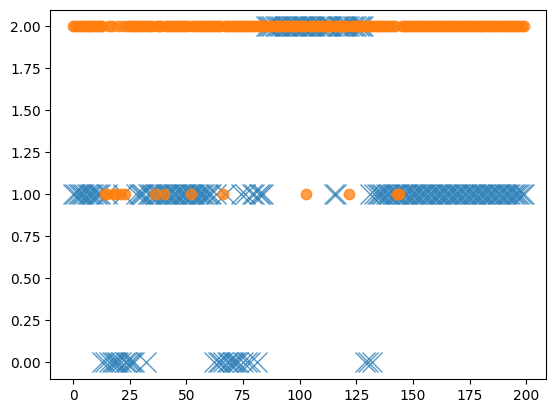

<Figure size 2000x600 with 0 Axes>

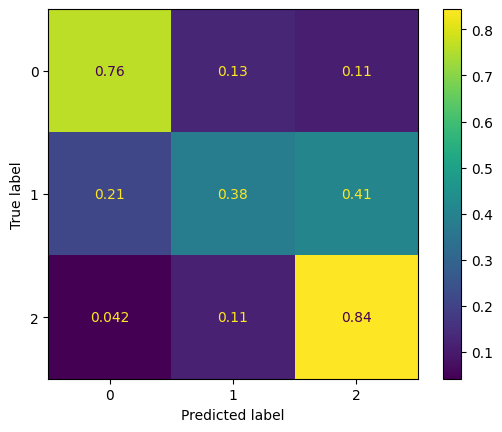

Sensitivity: [0.7644452  0.38130334 0.84397557]
Specificity: [0.82034609 0.87519562 0.72222631]
Precision: [0.72362052 0.75499232 0.28690072]
Class Accuracy: [0.7644452  0.38130334 0.84397557]
Overall Accuracy: 0.5813530710297364
[0.74347286 0.50670103 0.42822933]


0.5594677381229917

In [11]:
labels1 = None
preds1 = None
torch.backends.cudnn.enabled = False 
for test_dataloader in predict_loaders:
    labels, preds = ensemble(test_dataloader, 
                             base_model=bb_tfs, 
                            # added_model = transition_model,
                            # wake_model=two_class_transition, 
                            # rem_model=rem_model, 
                            # nrem_model=nrem_model,
                            alpha=1)
    #labels, preds = predict_transition(transition_model, test_dataloader, device, return_softmax=False, classes=5)
    
    # labels, preds = predict(wake_model, test_dataloader, device=device)
    if labels1 is None:
        labels1, preds1 = labels, preds
    else:
        labels1 = np.concatenate((labels1, labels), axis=0)
        preds1 = np.concatenate((preds1, preds), axis=0)

print(labels1)
print(preds1)
conf_mat = confusion_matrix(labels1, preds1, normalize="true")

print(np, sum(labels1) * 30 / 60 / 60)

plt.plot(labels1[12000:12200], marker="x", linestyle="", alpha=0.75, markersize=15)
plt.plot(preds1[12000:12200], marker=".", linestyle="", alpha=0.75, markersize=15)
plt.figure(figsize=(20,6))
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

sensitivity, specificity, precision, class_accuracy, accuracy  = calculate_metrics(preds1, labels1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("Class Accuracy:", class_accuracy)
print("Overall Accuracy:", accuracy)
calculate_macro_f1(preds1, labels1)
